Лабораторная работа № 3. Многослойные сети. Алгоритм обратного

распространения ошибки
Выполнил: Степанов Данила Михайлович

Группа: М8О-407Б-20

Вариант: 22

Цель работы

Исследование свойств многослойной нейронной сети прямого распространения и алгоритмов ее обучения, применение сети в задачах классификации и аппроксимации функции.

Решение

Подключим необходимые модули и функции: random нужен для генерации случайных значений, pyplot для построения необходимых графиков, torch для обучения нейронных сетей, функцию train_test_split для разбиения исходного множества данных на три выборки

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

Напишем функцию для генерации точек, принадлежащих эллипсу

In [ ]:
def generate_points(count, a, b):
  X = [random.uniform(-a, a) for i in range(count)]
  points = [(x, (b / a) * (random.randint(0,1)*2-1) * np.sqrt(a ** 2 - x ** 2)) for x in X]
  return points

Сгенерируем точки разных эллипсов и отобразим на графике

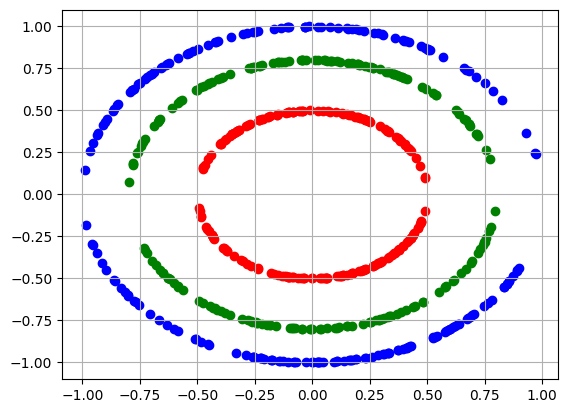

In [ ]:
points1 = generate_points(200, 0.5, 0.5)
points2 = generate_points(200, 0.8, 0.8)
points3 = generate_points(200, 1, 1)
x1 = [p[0] for p in points1]
y1 = [p[1] for p in points1]
x2 = [p[0] for p in points2]
y2 = [p[1] for p in points2]
x3 = [p[0] for p in points3]
y3 = [p[1] for p in points3]

plt.scatter(x1, y1, c="red")
plt.scatter(x2, y2, c="green")
plt.scatter(x3, y3, c="blue")
plt.grid(True)

Опишем модель нейронной сети для классификации точек на 3 класса

In [ ]:
class ClassificationModel(nn.Module):
  def __init__(self, hid_size, input_size, output_size): # определяем модель перечислением слоёв
    super().__init__()
    self.lin1 = nn.Linear(input_size, hid_size)
    self.activation = nn.Tanh()
    self.lin2 = nn.Linear(hid_size, output_size)

  def forward(self, x): # описываем подсчёт выходных значений нейронной сети
    x = self.lin1(x)
    x = self.activation(x)
    x = self.lin2(x)
    return x

напишем функцию, которая разделяет исходное множество на три набора согласно заданным размерам этих наборов

In [ ]:
def train_val_test_split(X, y, train_size_=0.7, test_size_=0.2, val_size_=0.1):
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size_)
  X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=test_size_)
  return X_train, y_train, X_test, y_test, X_val, y_val

Отдельно напишем функцию для создания тензоров для обучения нейронной сети

In [ ]:
def create_data(size1, size2, size3):
  points1 = generate_points(size1, 0.5, 0.5)
  points2 = generate_points(size2, 0.8, 0.8)
  points3 = generate_points(size3, 1, 1)
  size = size1 + size2 + size3
  labels = torch.reshape(torch.tensor([1, 0, 0] * size1 + [0, 1, 0] * size2 + [0, 0, 1] * size3, dtype=torch.float32), (size, 3))
  data = torch.tensor(points1 + points2 + points3, dtype=torch.float32)
  return data, labels

Создадим три набора данных, согласно условию лабораторной работы и проверим размеры

In [ ]:
X, y = create_data(100, 100, 100)
datasets = train_val_test_split(X, y)
for dataset in datasets:
  print(dataset.shape)

torch.Size([210, 2])
torch.Size([210, 3])
torch.Size([72, 2])
torch.Size([72, 3])
torch.Size([18, 2])
torch.Size([18, 3])


Опишем саму модель, функцию потерь, оптимизатор и функции для обучения модели и её оценки на тестовом наборе данных

In [ ]:
model = ClassificationModel(20, 2, 3)

opt = torch.optim.SGD(model.parameters(), lr=0.05)
criterion = torch.nn.CrossEntropyLoss()

def train(model, opt, criterion, X, y, epochs):
  model.train()
  history = []
  all = X.shape[0]
  for epoch in range(epochs):
    correct = 0.0
    opt.zero_grad()
    outputs = model(X)
    preds = torch.argmax(outputs, dim=1) # выбираем индекс, то есть класс, в котором модель больше всего уверена
    true_answers = torch.argmax(y, dim=1) # так как входные данные векторы, нам нужно и здесь выбрать класс, к которому относится объект
    correct += (preds == true_answers).sum() # подсчитываем долю верных ответов на текущем шаге обучения
    acc = (correct / all).item()
    loss = criterion(outputs, y)
    history.append(loss.item())
    loss.backward()
    opt.step()
    if epoch % 1000 == 0:
      print("epoch=", epoch, " acc: ", acc)
  return history

def evaluate(model, X, y):
  model.eval()
  all = X.shape[0]
  outputs = model(X)
  preds = torch.argmax(outputs, dim=1)
  true_answers = torch.argmax(y, dim=1)
  for index, point in enumerate(X): # получаем для каждой точки прогноз модели и отрисовываем её на графике. Цвет показывает к какому классу принадлежит объект
    #plt.annotate(str(true_answers[index].item()), (point[0], point[1]))
    if preds[index] == 0:
      plt.scatter(point[0], point[1], c="red")
    elif preds[index] == 1:
      plt.scatter(point[0], point[1], c="green")
    else:
      plt.scatter(point[0], point[1], c="blue")
  acc = ((preds == true_answers).sum() / all).item()
  #plt.legend(["0 class", "1 class", "2 class"])
  print("acc: ", acc)

Обучим модель на обучающей выборке

In [ ]:
epochs = 2300

history = train(model, opt, criterion, datasets[0], datasets[1], epochs)

epoch= 0  acc:  0.3619047701358795
epoch= 1000  acc:  0.7047619223594666
epoch= 2000  acc:  0.7095237970352173


Отобразим изменение значения функции потерь по мере обучения

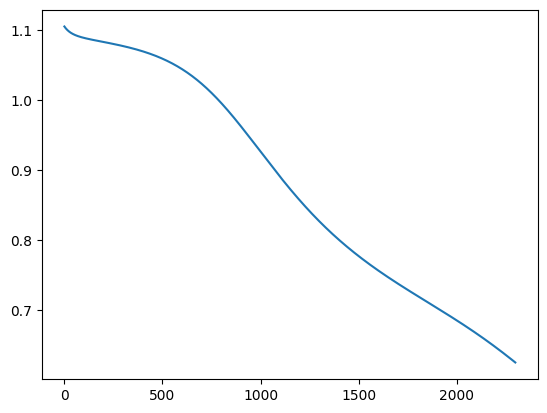

In [ ]:
plt.plot(range(epochs), history)

Оценим модель на тестовом наборе

acc:  0.6388888955116272


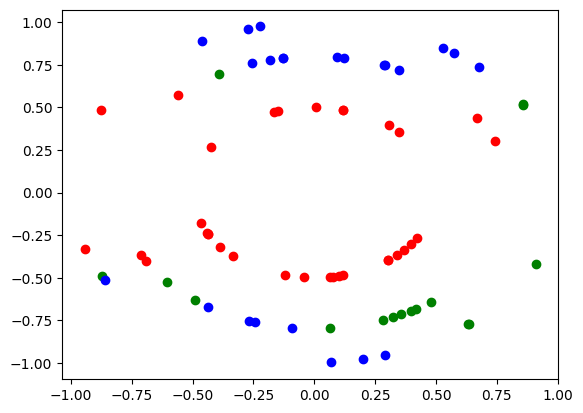

In [ ]:
evaluate(model, datasets[2], datasets[3])

### Часть 2 - аппроксимация функции

Опишем заданную по условию функцию и функцию,которая по условию работы и исходной функции генерирует обучающую выборку для нейронной сети

In [ ]:
x = lambda t: np.sin(-np.sin(t) * t ** 2 + t)

def generate_samples(f, start, finish, step):
    samples_size = int((finish - start) / step) # число элементов в выборке(объекты)
    t = [start + step * i for i in range(samples_size + 1)] # генерируем аргументы функции(предсказания на объектах)
    labels = [x(t) for t in t] # значения аппроксимируемой функции в точках множества t
    X = torch.reshape(torch.tensor(t, dtype=torch.float32), (samples_size + 1, 1)) # создаём из аргументов тензор для обучения
    y = torch.reshape(torch.tensor(labels, dtype=torch.float32), (samples_size + 1, 1)) # создаём из предсказаний тензор для обучения
    return X, y

X, y = generate_samples(x, 0.5, 4.0, 0.01)

Опишем модель для аппроксимации функции перечислением слоёв

In [ ]:
class ApproximationModel(nn.Module):
  def __init__(self, hid_size): # перечисляем слои нейронной сети
    super().__init__()
    self.hid_size = hid_size
    self.lin1 = nn.Linear(1, hid_size)
    self.lin2 = nn.Linear(hid_size, 1)
    self.tanh = nn.Tanh()

  def forward(self, x): # описываем подсчёт выходных значений нейронной сети
    x = self.lin1(x)
    x = self.tanh(x)
    x = self.lin2(x)
    x = self.tanh(x)
    return x

Определяем нашу модель, функцию потерь, оптимизатор и процедуру обучения

In [ ]:
X = X.to(torch.float32)

model = ApproximationModel(10)

criterion = torch.nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

epochs = 200000
history = []

for epoch in range(epochs):
  model.zero_grad()
  outputs = model(X)
  loss = criterion(outputs, y)
  history.append(loss.item())
  loss.backward()
  opt.step()
  if epoch % 10000 == 0:
    print("loss: ", loss.item())

loss:  0.5029069781303406
loss:  0.1269381195306778
loss:  0.10330212116241455
loss:  0.078339122235775
loss:  0.056644223630428314
loss:  0.041183095425367355
loss:  0.02960689552128315
loss:  0.025928424671292305
loss:  0.024141032248735428
loss:  0.023128243163228035
loss:  0.022523459047079086
loss:  0.02213134430348873
loss:  0.021976890042424202
loss:  0.021666686981916428
loss:  0.02152029052376747
loss:  0.021446142345666885
loss:  0.021386228501796722
loss:  0.021244985982775688
loss:  0.02118392288684845
loss:  0.021152669563889503


Построим график изменения функции потерь по мере обучения

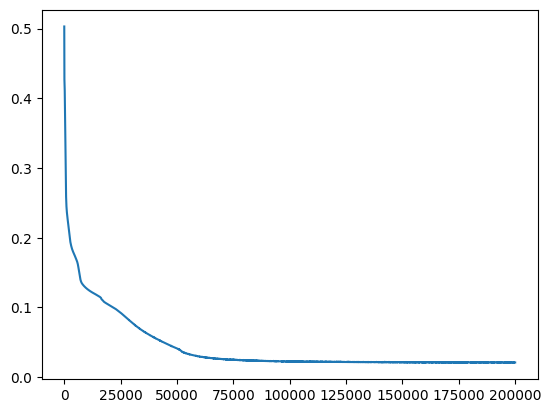

In [ ]:
plt.plot(range(epochs), history)

Опишем функцию, которая строит исходную функцию на заданном отрезке и значения модели, аппроксимирующей заданную функцию

In [ ]:
def compare_functions(target_function, model, X, y, a, b, size):
  model.eval()
  outputs = torch.reshape(model(X), (X.shape[0],)).detach().numpy()
  plt.plot(np.linspace(a, b, size), y.detach().numpy(), c="red")
  plt.plot(np.linspace(a, b, size), outputs)
  plt.legend(["Исходная функциия", "Аппроксимация функции"])

Проверим, насколько модель хорошо аппроксимирует заданнную функцию

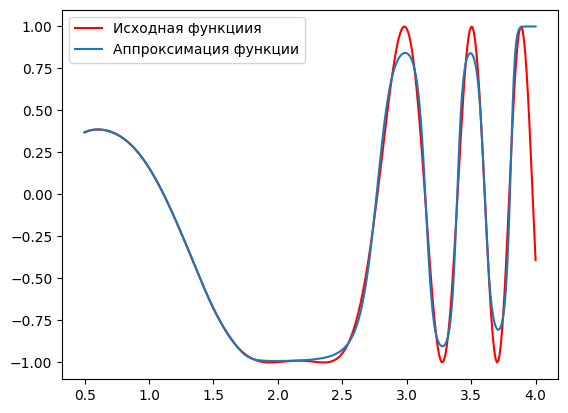

In [ ]:
compare_functions(x, model, X, y, 0.5, 4.0, 351)

Вывод

В данной лабораторной работе я применил многослойную линейную нейронную сеть для решения задач классификации линейно неразделимых объектов и аппроксимации функции. Для решения этих задач я добавил нелинейные функции активации. В процессе выполнения лабораторной работы я заметил, что модели легко переобучаются под обучающие данные: в первой задачи при длительном обучении модель правильно классифицирует 99% точек обучающей выборки, а во второй-модель почти идеально аппроксимирует заданную функцию, однако это приводит к проблемам, когда поступают новые данные, к которым модель не готова. Чтобы улучшить качество на тестовом наборе я уменьшил число итераций обучения.